In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
import scipy.stats
import gzip
from tqdm.auto import tqdm
from utils import fit_exp

In [2]:
# relevant data and background for what the plots mean can be found here
# https://healthweather.us/

In [3]:
yahist.utils.set_default_style()

In [4]:
data_dir = "../sources/healthweather/data"
state_abbrevs = "AL AZ AR CA CO CT DE FL GA ID IL IN IA KS KY LA ME MD MA MI MN MS MO MT NE NV NH NJ NM NY NC ND OH OK OR PA RI SC SD TN TX UT VT VA WA WV WI WY".split()

def get_df(state="CA"):
    js = json.load(gzip.open(f"{data_dir}/states/{state}_data.json.gz"))
    dfc = pd.DataFrame(js["data"], columns=js["columns"])
    dfc["date"] = pd.to_datetime(dfc["date"])
    dfc = dfc.set_index("date")
    dfc["days_ago"] = -(dfc.index - pd.Timestamp.now()).total_seconds()/86400
    dfc["region_name"] = dfc["region_name"].str.replace(" County","",1)
    return dfc

dfc = get_df("CA")
dfc.head()

,region_id,region_name,region_type,state,observed_ili,atypical_ili,atypical_ili_delta,anomaly_fevers,forecast_expected,forecast_lower,forecast_upper,days_ago
date,,,,,,,,,,,,
2020-02-16,06041,Marin,county,CA,6.429078,NaN,0.0,0.0,NaN,NaN,NaN,121.876999
2020-02-16,06039,Madera,county,CA,6.585115,NaN,0.0,0.0,NaN,NaN,NaN,121.876999
2020-02-16,06045,Mendocino,county,CA,6.182909,NaN,0.0,0.0,NaN,NaN,NaN,121.876999
2020-02-16,06043,Mariposa,county,CA,6.474346,NaN,NaN,NaN,NaN,NaN,NaN,121.876999
2020-02-16,06037,Los Angeles,county,CA,6.727377,NaN,0.0,0.0,NaN,NaN,NaN,121.876999


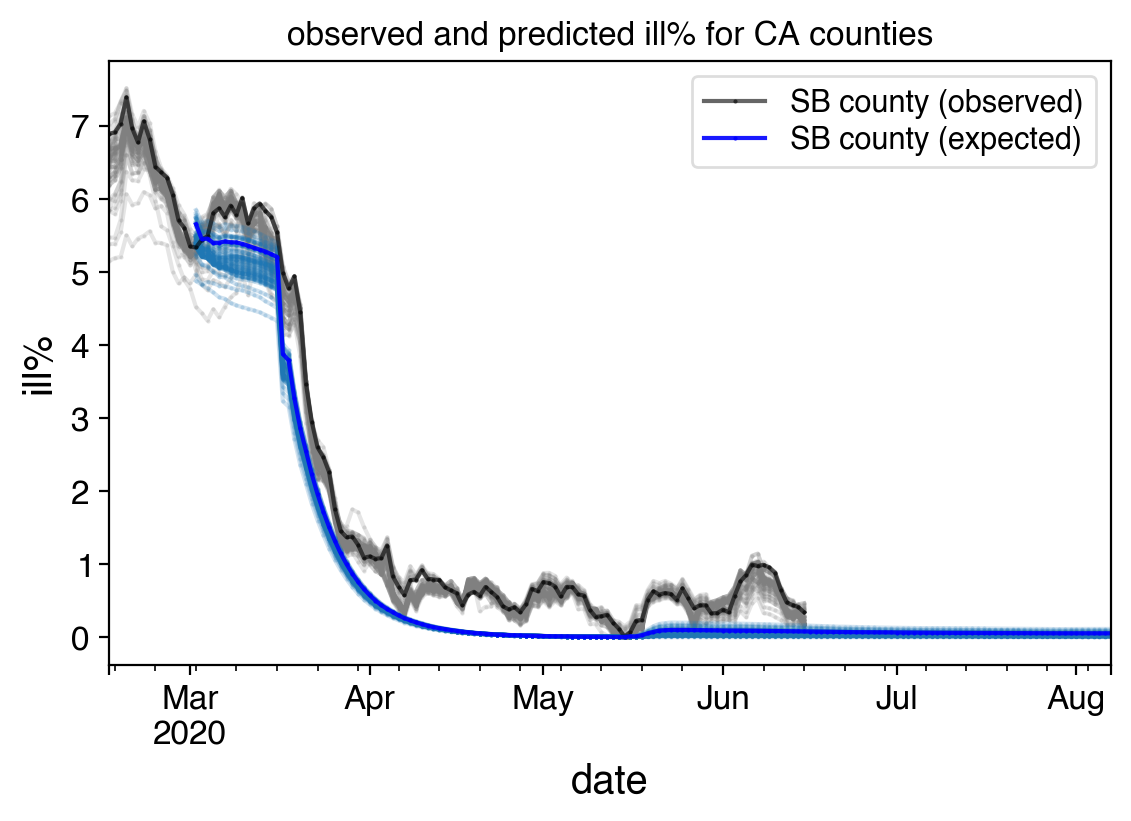

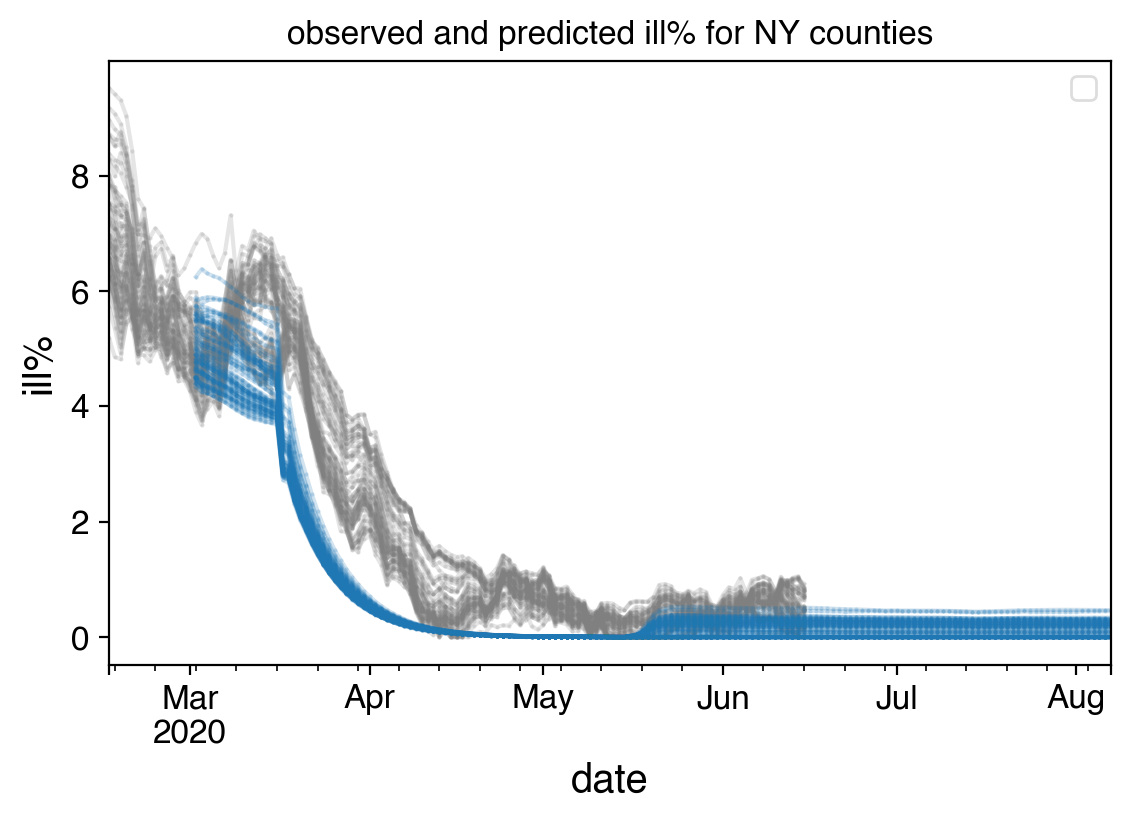

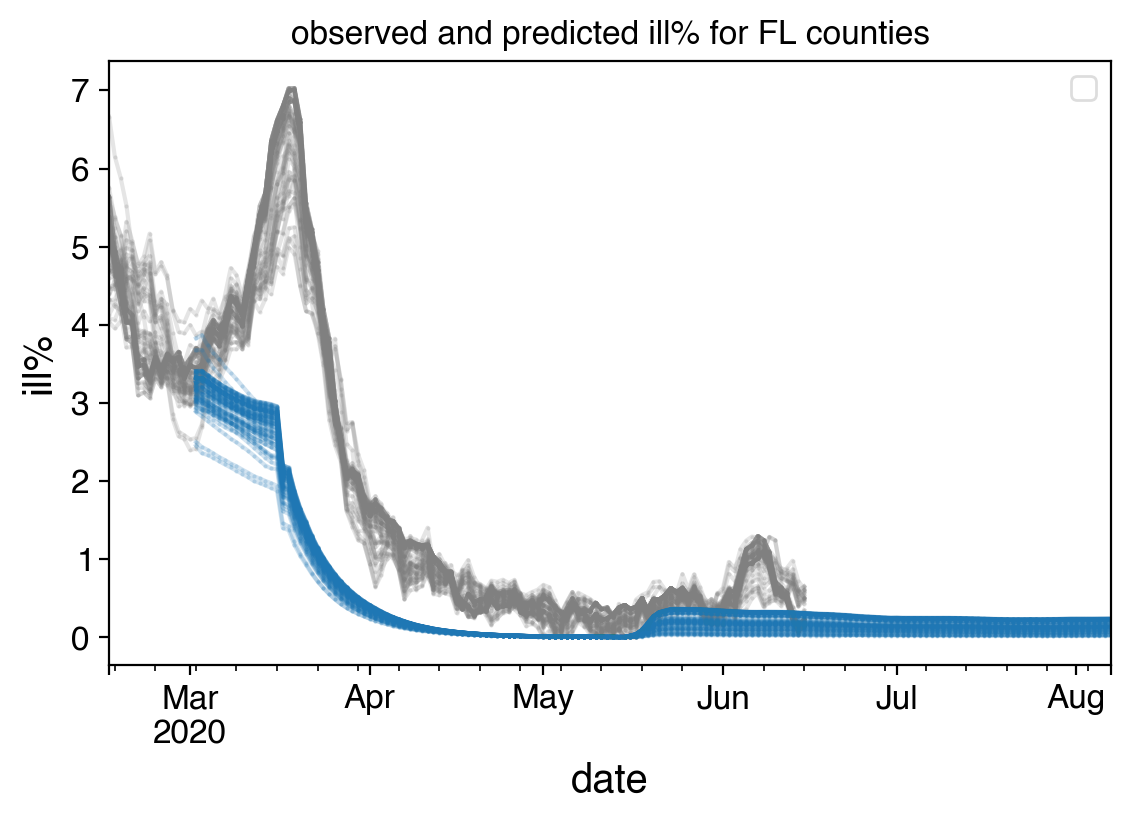

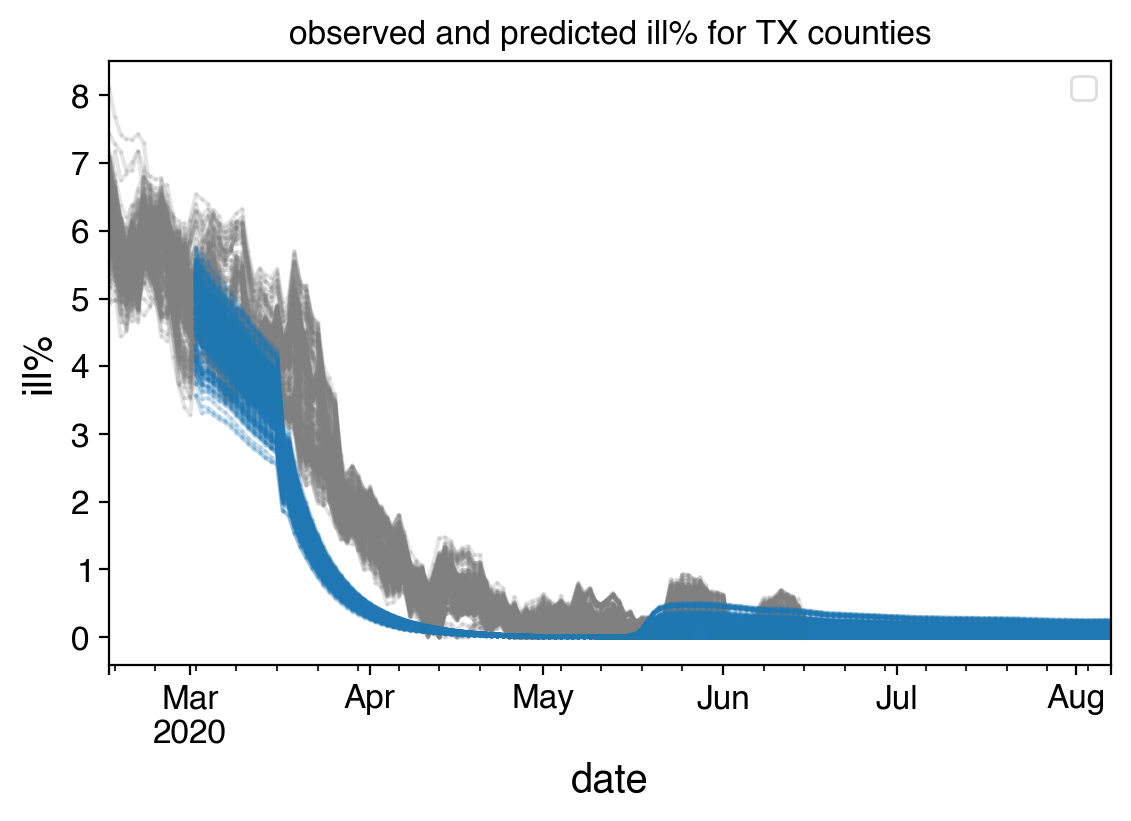

In [7]:
for state in [
    "CA", "NY", "FL", "TX",
]:

    dfc = get_df(state)

    fig, ax = plt.subplots()

    gb = dfc.groupby("region_name")
    gb["observed_ili"].plot(ax=ax, color="gray", ms=0.5, marker="o", alpha=0.2, label="");

    gb["forecast_expected"].plot(ax=ax, color="C0", ms=0.5, marker="o", alpha=0.2, label="");

    ax.legend([])

    if state == "CA":
        dfc.query("region_name=='Santa Barbara'")["observed_ili"].plot(
            ax=ax, color="black", ms=0.5, marker="o", alpha=0.6, label="SB county (observed)"
        );
        dfc.query("region_name=='Santa Barbara'")["forecast_expected"].plot(
            ax=ax, color="blue", ms=0.5, marker="o", alpha=0.9, label="SB county (expected)"
        );
        ax.legend()

    ax.set_title(f"observed and predicted ill% for {state} counties")
    ax.set_ylabel("ill%")

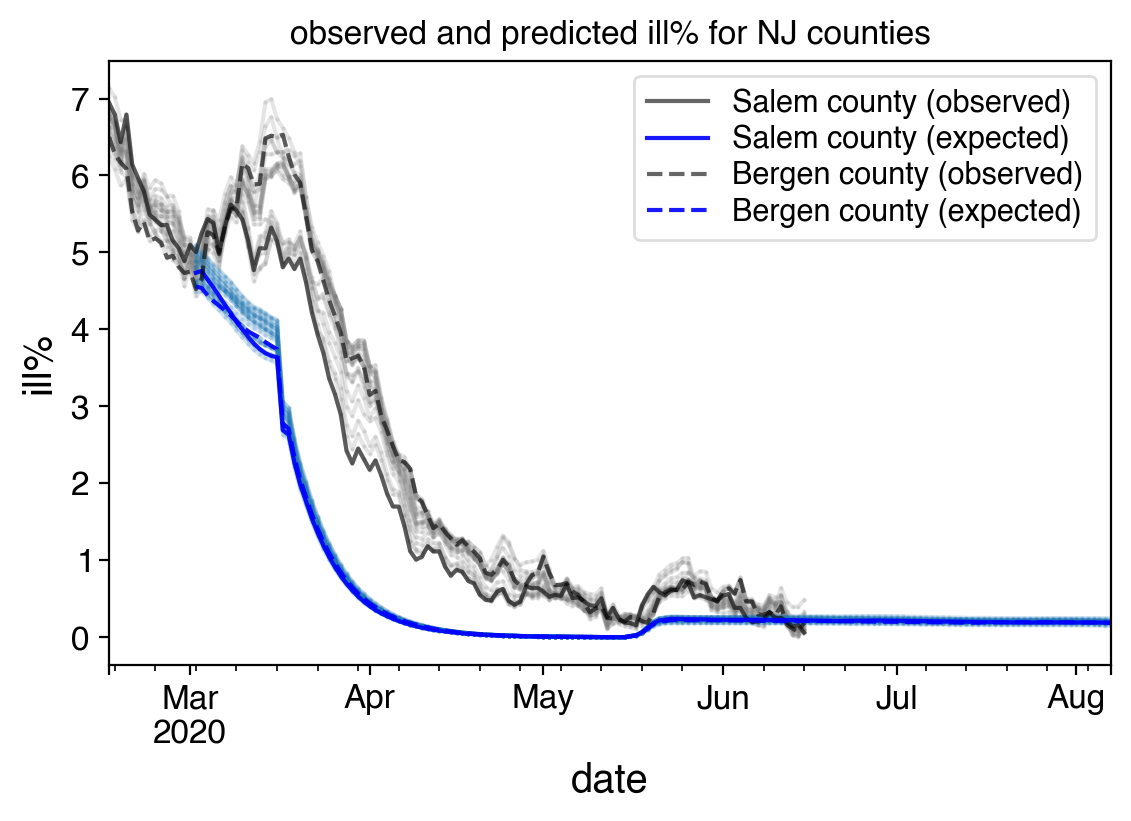

In [8]:

for state in [
    "NJ",
#     "NY",
#     "CA",
#     "AZ",
]:

    dfc = get_df(state)

    fig, ax = plt.subplots()

    gb = dfc.groupby("region_name")
    gb["observed_ili"].plot(ax=ax, color="gray", ms=0.5, marker="o", alpha=0.2, label="");

    gb["forecast_expected"].plot(ax=ax, color="C0", ms=0.5, marker="o", alpha=0.2, label="");

    ax.legend([])

    linestyles = (ls for ls in ["solid","dashed","dotted","dashdot"])
    for county in [
        "Salem",
        "Bergen",
        
#         "New York",
#         "Yates",
#         "Seneca",
#         "Suffolk",
        
#         "San Francisco",
#         "Los Angeles",
        
#         "Maricopa","Apache",
    ]:
        ls = next(linestyles)
        dfc.query(f"region_name=='{county}'")["observed_ili"].plot(
            ax=ax, color="black", ms=0.0, marker="o", alpha=0.6, label=f"{county} county (observed)",
            linestyle = ls,
        );
        dfc.query(f"region_name=='{county}'")["forecast_expected"].plot(
            ax=ax, color="blue", ms=0.0, marker="o", alpha=0.9, label=f"{county} county (expected)",
            linestyle = ls,
        );
        ax.legend()

    ax.set_title(f"observed and predicted ill% for {state} counties")
    ax.set_ylabel("ill%")

In [7]:
# compute a "z-score" by comparing observed to expected ill%
def calc_zscore(row):
    obs = row["observed_ili"]
    exp = row["forecast_expected"]
    up = row["forecast_upper"] - exp
    down = exp - row["forecast_lower"]
    if obs > exp: return (obs-exp)/up
    if obs < exp: return (obs-exp)/down
    
def get_zscores(dfc, days_ago=14, ndays=999):
    df = dfc[~dfc[["forecast_expected","observed_ili"]].isna().any(axis=1)].query(f"{days_ago-ndays}<days_ago<{days_ago}")
    df["z"] = df.apply(calc_zscore, axis=1)
    return df.groupby("region_name")["z"].mean()
    return df["z"]

Text(0.5, 1.0, 'mean z-scores per county in CA')

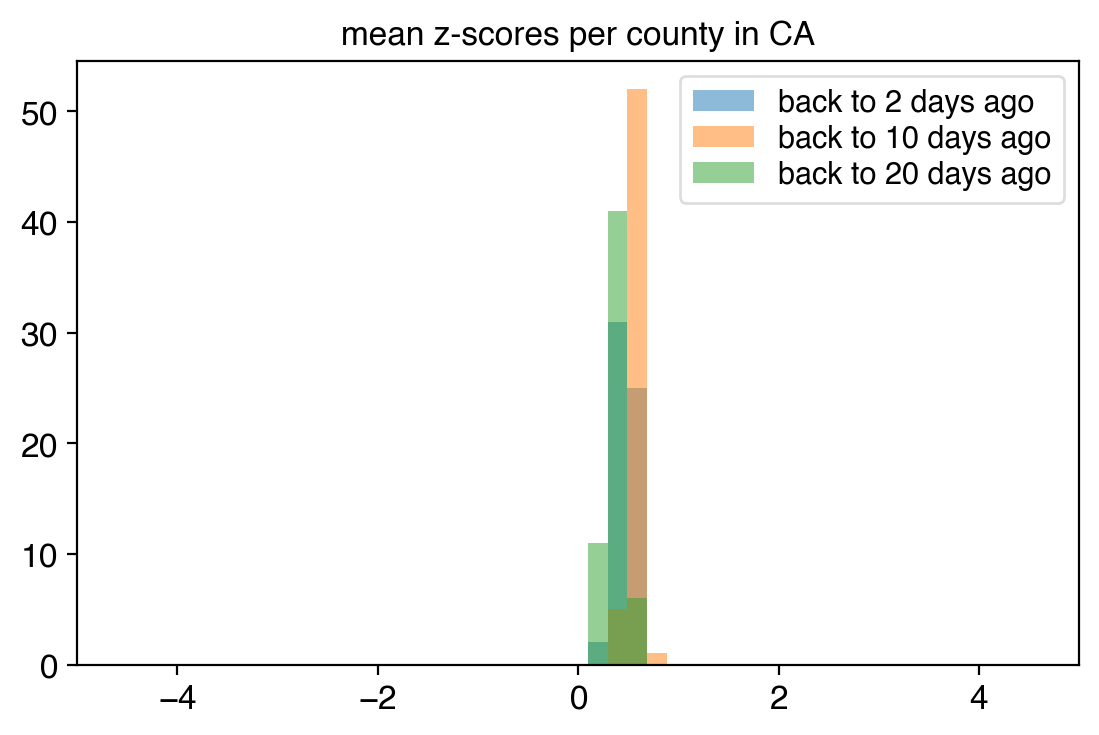

In [8]:
state = "CA"
fig, ax = plt.subplots()
for days_ago in [2,10,20]:
    Hist1D(get_zscores(get_df(state), days_ago=days_ago), bins="51,-5,5").plot(ax=ax, label=f"back to {days_ago} days ago",alpha=0.5)
ax.legend()
ax.set_title(f"mean z-scores per county in {state}")

In [9]:
df_cases_raw = pd.read_json("../sources/1point3acres/data/cases_and_deaths.json.gz").query("not is_death")
df_cases_raw["date"] = pd.to_datetime(df_cases_raw["date"])
# Require state abbreviation to be length 2 (otherwise diamond princess/etc would get included)
df_cases = df_cases_raw[df_cases_raw["state"].str.len() == 2]
df_cases = df_cases.groupby(["state","county"])[["ngroup"]].count().reset_index().rename({"ngroup":"cases"},axis=1)
print(len(df_cases))
df_cases.head()

2173


,state,county,cases
0,AK,Anchorage,55
1,AK,Eagle River,5
2,AK,Fairbanks North Star,22
3,AK,Gridwood,1
4,AK,Homer,2


In [10]:
dfs = []
for state in tqdm(state_abbrevs):
    df = pd.DataFrame()
    vals = get_zscores(get_df(state), days_ago=14)
    df["county"] = vals.index
    df["z"] = vals.values
    df["state"] = state
    dfs.append(df)
df_zscores = pd.concat(dfs)
print(len(df_zscores))
df_zscores.head()


3108


,county,z,state
0,Autauga,-0.407427,AL
1,Baldwin,0.093051,AL
2,Barbour,0.161036,AL
3,Bibb,-0.484780,AL
4,Blount,0.046461,AL


In [11]:
len(df_cases_raw.groupby(["state","county"]))

2181

In [12]:
# merge cases and z-scores
df_both = df_zscores.merge(df_cases, how="left", on=["state","county"]).fillna(0)

# merge in population
df_pop = pd.read_json("../sources/census/data/county_populations.json.gz")
df_pop["county"] = (df_pop["county"]
                   .str.replace(" Municipality","")
                   .str.replace(" County","")
                   .str.replace(" Borough","")
                   .str.replace(" Parish","")
                   .str.replace(" city","",case=True))
df_both = df_both.merge(df_pop,on=["state","county"], how="inner")

print(len(df_both))
df_both.head()

3003


,county,z,state,cases,population
0,Autauga,-0.407427,AL,7.0,55869
1,Baldwin,0.093051,AL,18.0,223234
2,Barbour,0.161036,AL,0.0,24686
3,Bibb,-0.484780,AL,2.0,22394
4,Blount,0.046461,AL,5.0,57826


In [13]:
df = df_both.query("cases>2")
x = np.log10(df["cases"])
y = df["z"]
slope, intercept, rval, pval, _ = scipy.stats.linregress(x, y)
rsq = rval**2
label = rf"$r^2$={rsq:.2f}"
print(label)

$r^2$=0.03


Text(0.5, 1.0, 'per county z-scores (from healthweather.us) vs covid19 cases')

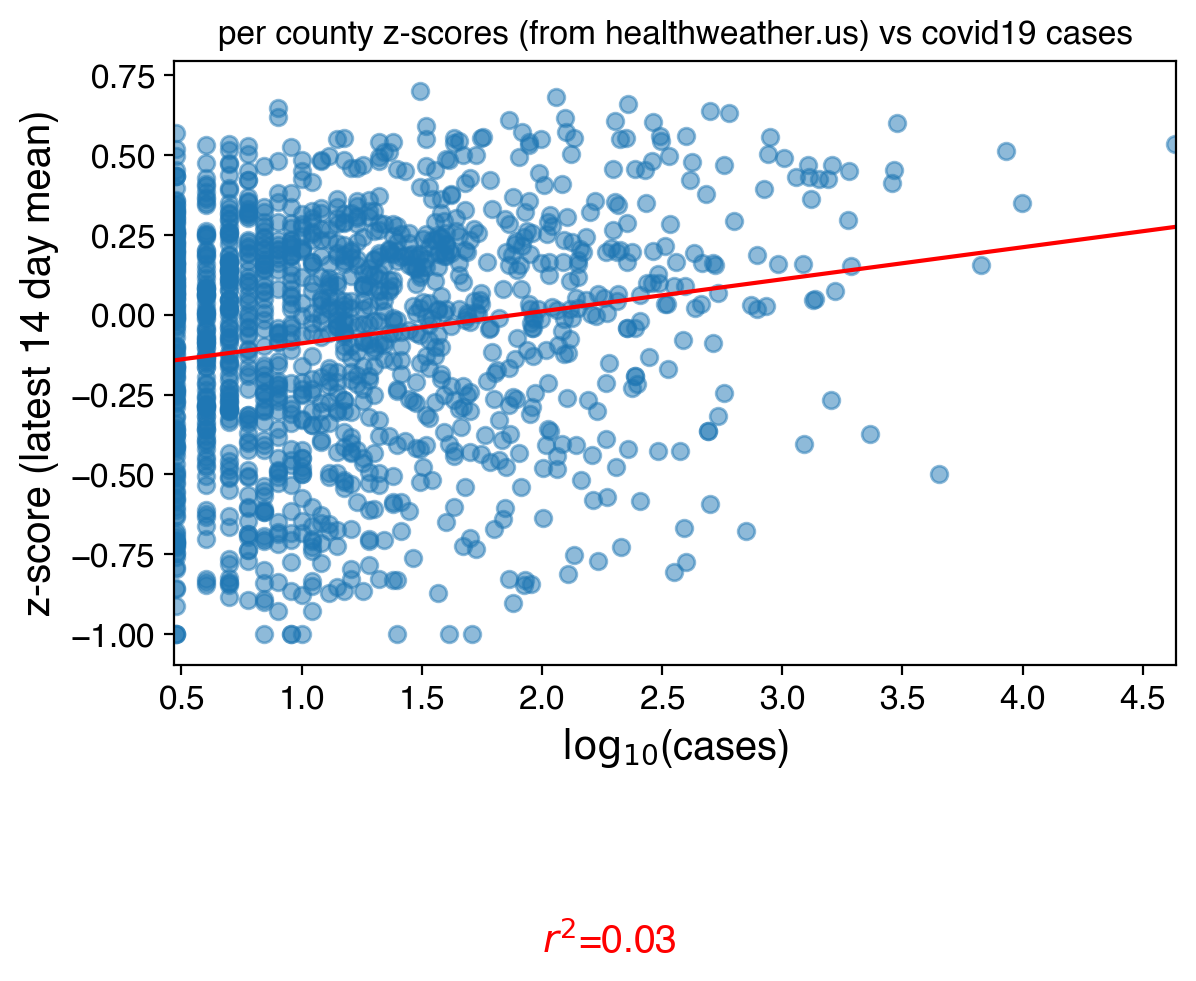

In [14]:
fig, ax = plt.subplots()
ax.scatter(x, y, marker="o", alpha=0.5)

xs = np.linspace(*ax.get_xlim(), 100)
ys = slope*xs + intercept
ax.plot(xs,ys, color="red")

ax.text(2, -2., label, color="red", fontsize=14)
ax.set_xlabel(r"$\mathrm{log}_{10}$(cases)")
ax.set_ylabel("z-score (latest 14 day mean)")

ax.set_title("per county z-scores (from healthweather.us) vs covid19 cases")

/Users/namin/sandbox/dev/yahist/yahist/hist2d.py:137: RuntimeWarning: invalid value encountered in true_divide
  r_val = num / den
/Users/namin/sandbox/dev/yahist/yahist/hist2d.py:138: RuntimeWarning: invalid value encountered in true_divide
  r_err = ((num_err / den) ** 2 + (den_err * num / den ** 2.0) ** 2.0) ** 0.5


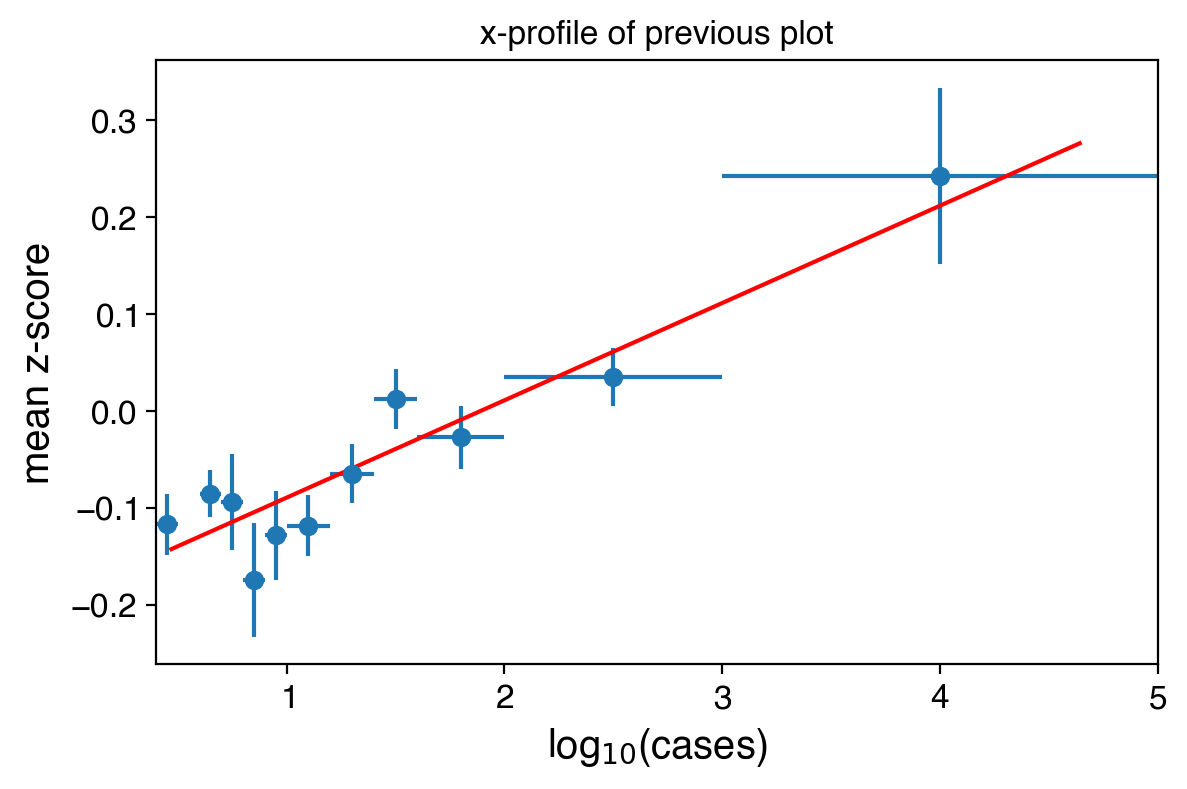

In [15]:
df = df_both.query("cases>2")
x = np.log10(df["cases"])
y = df["z"]

xbins = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,2.0,3.,5])
# yahist.Hist2D(np.c_[x,y], bins=[np.linspace(0,5,10), np.linspace(-6,6,100)]).x_profile().plot(show_errors=True)
fig, ax = plt.subplots()
yahist.Hist2D(np.c_[x,y], bins=[xbins, np.linspace(-6,6,100)]).x_profile().plot(show_errors=True)
ax.set_xlabel("log${}_{10}$(cases)")
ax.set_ylabel("mean z-score")
ax.set_title("x-profile of previous plot")

ax.plot(xs,ys, color="red")
# x